Project 3 - Training Networks with Tensorflow and Keras.

Professor: Amir Sadovnik

Course: Computer Science 424/525 - Deep Learning

Team Members: William Parham, Coby White

Due Date: April 7, 2023

Description: This lab will help us gain experience using Tensorflow when building Sequential and Non-Sequential Neural Networks as well guide us in Building Fully Connected and Convolutional Networks.

In [41]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorboard import notebook
notebook.list()

%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 18474), started 4:00:08 ago. (Use '!kill 18474' to kill it.)

Task 1 of Project 3.  Fully Connected Neural Network.

In [75]:
def run_task_1(training_images, testing_images, training_labels, testing_labels, task, type):
    #Construct network model
    task1_model = Sequential()
    task1_model.add(layers.Dense(units=1024,input_shape=(1024,), activation='tanh'))
    task1_model.add(layers.Dense(units=512, activation='sigmoid'))
    task1_model.add(layers.Dense(units=100, activation='relu'))
    if (task == 'gender'):
        task1_model.add(layers.Dense(units=2, activation='softmax'))
    else:
        task1_model.add(layers.Dense(units=7, activation='softmax'))
        
    #Compile our network and set optimizer as well as loss function
    task1_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
     
    #Create and fit the scaler to the data
    scaler = MinMaxScaler()
    scaled_training_images=scaler.fit_transform(training_images)
    scaled_testing_images=scaler.transform(testing_images)
    
    if(type == 'train'):
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(scaled_training_images, encoded_training_labels,
                                                        test_size=0.33, random_state=42)
        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
        #fit the network to the training data
        task1_model.fit(x=X_train,y=y_train, epochs=5, callbacks=[tensorboard_callback])
    
        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task1_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])
    
        #perform our prediction
        cm = task1_model.predict(x=X_test)
    
        print(len(cm))
        sn.heatmap(cm, annot=False)
    else:
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(scaled_testing_images, encoded_testing_labels,
                                                        test_size=0.33, random_state=42)
        
        #fit the network to the testing data
        task1_model.fit(x=X_train,y=y_train, epochs=5)
    
        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task1_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])
    
        #perform our prediction
        cm = task1_model.predict(x=X_test)
    
        x = sn.heatmap(cm, annot=False)
    
    return task1_model

Epoch 1/5
21/21 [==============================] - 1s 8ms/step - loss: 0.6948 - accuracy: 0.5224
Epoch 2/5
21/21 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.5418
Epoch 3/5
21/21 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.5254
Epoch 4/5
21/21 [==============================] - 0s 13ms/step - loss: 0.6879 - accuracy: 0.5448
Epoch 5/5
21/21 [==============================] - 0s 10ms/step - loss: 0.6870 - accuracy: 0.5403
11/11 - 0s - loss: 0.6747 - accuracy: 0.6030 - 197ms/epoch - 18ms/step
Test loss: 0.674717128276825
Test accuracy: 0.6030303239822388
330


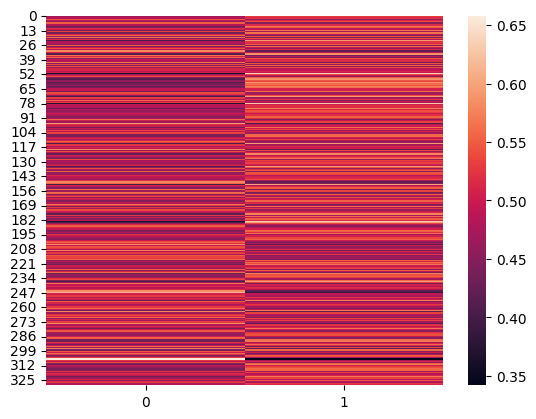

In [76]:
#read in training and testing csv with labels for our data
training_labels = pd.read_csv('fairface_label_train.csv', nrows=1000)
testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)

task = 'gender'
type = 'train'

if(task == 'gender'):
    training_labels=training_labels.drop('race',axis=1)    
    testing_labels=testing_labels.drop('race',axis=1)
else:
    training_labels=training_labels.drop('gender', axis=1)    
    testing_labels=testing_labels.drop('gender', axis=1)

training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)


testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)

#read in images that we will be predicting on
training_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    testing_images[i-1]=im


#This method runs task 1 with the training data and tests on the testing data from a train test split.
#If task is set to 'gender', it will run the model to predict gender, otherwise it will predict race.
#If type is set to train, it will run the model with training data, otherwise it will run with validation data.
if(type=='train'):
    mod = run_task_1(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='train')
else:
    mod = run_task_1(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='test')

Task 2 of Project 3.   Small Convolutional Neural Network.

In [67]:
def run_task_2(training_images, testing_images, training_labels, testing_labels, task, type):
    #build the network
    task2_model = Sequential()
    task2_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task2_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task2_model.add(layers.Flatten())
    task2_model.add(layers.Dense(units=100, activation='relu'))
    if (task == 'gender'):
        task2_model.add(layers.Dense(units=2, activation='softmax'))
    else:
        task2_model.add(layers.Dense(units=7, activation='softmax'))
    
    task2_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    if(type == 'train'):
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(training_images, encoded_training_labels,
                                                    test_size=0.33, random_state=42)
        #fit the network to the training data
        task2_model.fit(x=X_train,y=y_train, epochs=5)

        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task2_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])

        #perform our prediction
        cm = task2_model.predict(x=X_test)

        print(len(cm))
        sn.heatmap(cm, annot=False)
    else:
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(training_images, encoded_testing_labels,
                                                        test_size=0.33, random_state=42)
        
        #fit the network to the testing data
        task2_model.fit(x=X_train,y=y_train, epochs=5)
    
        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task2_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])
    
        #perform our prediction
        cm = task2_model.predict(x=X_test)
    
        sn.heatmap(cm, annot=False)
    

Epoch 1/5
21/21 [==============================] - 1s 12ms/step - loss: 0.6961 - accuracy: 0.4955
Epoch 2/5
21/21 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.5358
Epoch 3/5
21/21 [==============================] - 0s 16ms/step - loss: 0.6850 - accuracy: 0.5537
Epoch 4/5
21/21 [==============================] - 0s 16ms/step - loss: 0.6800 - accuracy: 0.5851
Epoch 5/5
21/21 [==============================] - 0s 13ms/step - loss: 0.6759 - accuracy: 0.6030
11/11 - 0s - loss: 0.6799 - accuracy: 0.5970 - 195ms/epoch - 18ms/step
Test loss: 0.6798632740974426
Test accuracy: 0.596969723701477
330


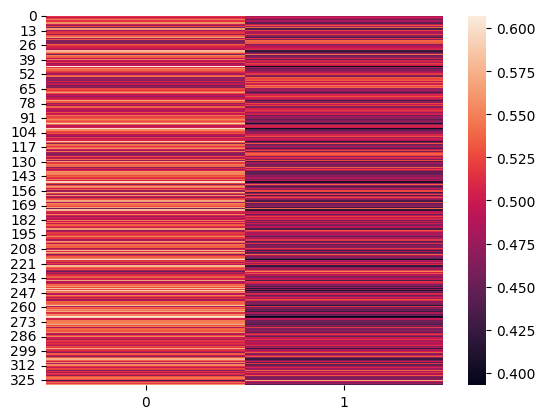

In [68]:
#read in training and testing csv with labels for our data
training_labels = pd.read_csv('fairface_label_train.csv', nrows=1000)
testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)

task = 'gender'
type = 'train'

if(task == 'gender'):
    training_labels=training_labels.drop('race',axis=1)    
    testing_labels=testing_labels.drop('race',axis=1)
else:
    training_labels=training_labels.drop('gender', axis=1)    
    testing_labels=testing_labels.drop('gender', axis=1)

training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)


testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

#This method runs task 2 with the training data and tests on the testing data from a train test split.
#If task is set to 'gender', it will run the model to predict gender, otherwise it will predict race.
#If type is set to train, it will run the model with training data, otherwise it will run with validation data.
if(type=='train'):
    mod = run_task_2(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='train')
else:
    mod = run_task_2(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='test')

Task 3 of Project 3.  Create our own convolutional layer.

In [69]:
def run_task_3(training_images, testing_images, training_labels, testing_labels, task, type):
    #build the network
    task3_model = Sequential()
    task3_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Flatten())
    task3_model.add(layers.Dense(units=100, activation='relu'))
    if (task == 'gender'):
        task3_model.add(layers.Dense(units=2, activation='softmax'))
    else:
        task3_model.add(layers.Dense(units=7, activation='softmax'))
    
    task3_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    if(type == 'train'):
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(training_images, encoded_training_labels,
                                                    test_size=0.33, random_state=42)
        #fit the network to the training data
        task3_model.fit(x=X_train,y=y_train, epochs=5)

        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task3_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])

        #perform our prediction
        cm = task3_model.predict(x=X_test)

        plt.xlabel('genders')
        plt.ylabel('faces')
        sn.heatmap(cm, annot=False)
        
    else:
        #split both our training data and testing(validation set) data into train-test splits
        X_train, X_test, y_train, y_test = train_test_split(training_images, encoded_testing_labels,
                                                        test_size=0.33, random_state=42)
        
        #fit the network to the testing data
        task3_model.fit(x=X_train,y=y_train, epochs=5)
    
        #call model.evaluate for the final test loss and final test accuracy
        test_scores = task3_model.evaluate(x=X_test, y=y_test, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])
    
        #perform our prediction
        cm = task3_model.predict(x=X_test)
    
        sn.heatmap(cm, annot=False)
    

Epoch 1/5
21/21 [==============================] - 1s 21ms/step - loss: 0.6967 - accuracy: 0.4851
Epoch 2/5
21/21 [==============================] - 0s 22ms/step - loss: 0.6907 - accuracy: 0.5239
Epoch 3/5
21/21 [==============================] - 0s 22ms/step - loss: 0.6899 - accuracy: 0.5313
Epoch 4/5
21/21 [==============================] - 0s 19ms/step - loss: 0.6886 - accuracy: 0.5343
Epoch 5/5
21/21 [==============================] - 0s 19ms/step - loss: 0.6877 - accuracy: 0.5254
11/11 - 0s - loss: 0.6846 - accuracy: 0.5909 - 146ms/epoch - 13ms/step
Test loss: 0.684565007686615
Test accuracy: 0.5909090638160706


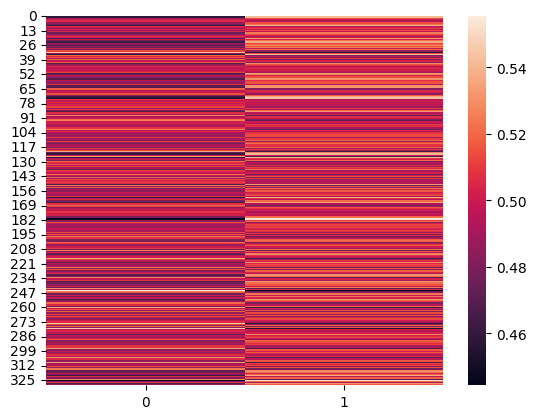

In [70]:
#read in training and testing csv with labels for our data
training_labels = pd.read_csv('fairface_label_train.csv', nrows=1000)
testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)

task = 'gender'
type = 'train'

if(task == 'gender'):
    training_labels=training_labels.drop('race',axis=1)    
    testing_labels=testing_labels.drop('race',axis=1)
else:
    training_labels=training_labels.drop('gender', axis=1)    
    testing_labels=testing_labels.drop('gender', axis=1)

training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)


testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

#This method runs task 2 with the training data and tests on the testing data from a train test split.
#If task is set to 'gender', it will run the model to predict gender, otherwise it will predict race.
#If type is set to train, it will run the model with training data, otherwise it will run with validation data.
if(type=='train'):
    mod = run_task_3(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='train')
else:
    mod = run_task_3(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels, task=task, type='test')

Task 4 of Project 3.  Create Your Own Convolutional Neural Network On Both Tasks Simultaneously.

In [71]:
def run_task_4(training_images, testing_images, training_labels, testing_labels):
    #build the network
    x = layers.Input(shape=(32,32,1))
    hidden1 = layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1))(x)
    hidden2 = layers.MaxPooling2D(pool_size=(2,2))(hidden1)
    hidden3 = layers.Flatten()(hidden2)
    hidden_branch4 = layers.Dense(units=100, activation='relu')(hidden3)
    output1 = layers.Dense(units=2, activation='softmax')(hidden_branch4)
    hidden_branch5 = layers.Dense(units=100, activation='relu')(hidden3)
    output2 = layers.Dense(units=7, activation='softmax', )(hidden_branch5)
    task4_model = Model(inputs=x, outputs=[output1,output2])
    

    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.fit_transform(testing_images[i])
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels_gender = enc.fit_transform(training_labels[0])
    encoded_training_labels_race = enc.fit_transform(training_labels[1])
    
    encoded_testing_labels_gender = enc.fit_transform(testing_labels[0])
    encoded_testing_labels_race = enc.fit_transform(testing_labels[1])

    task4_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task4_model.fit(x=training_images,y=[encoded_training_labels_gender,encoded_training_labels_race], epochs=5, validation_split=0.2)
    cm = task4_model.predict(x=testing_images)
    
    test_scores = task4_model.evaluate(x=testing_images, y=[encoded_testing_labels_gender, encoded_testing_labels_race],verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    sn.heatmap(cm[1], annot=False)

Epoch 1/5
25/25 [==============================] - 1s 30ms/step - loss: 2.6186 - dense_113_loss: 0.6908 - dense_115_loss: 1.9278 - dense_113_accuracy: 0.5175 - dense_115_accuracy: 0.1775 - val_loss: 2.6143 - val_dense_113_loss: 0.6887 - val_dense_115_loss: 1.9255 - val_dense_113_accuracy: 0.5450 - val_dense_115_accuracy: 0.1750
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 2.5978 - dense_113_loss: 0.6843 - dense_115_loss: 1.9135 - dense_113_accuracy: 0.5725 - dense_115_accuracy: 0.1875 - val_loss: 2.6173 - val_dense_113_loss: 0.6907 - val_dense_115_loss: 1.9266 - val_dense_113_accuracy: 0.5450 - val_dense_115_accuracy: 0.1750
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 2.5785 - dense_113_loss: 0.6784 - dense_115_loss: 1.9001 - dense_113_accuracy: 0.5675 - dense_115_accuracy: 0.2100 - val_loss: 2.6131 - val_dense_113_loss: 0.6980 - val_dense_115_loss: 1.9151 - val_dense_113_accuracy: 0.5300 - val_dense_115_accuracy: 0.1650
Epoch 4/5


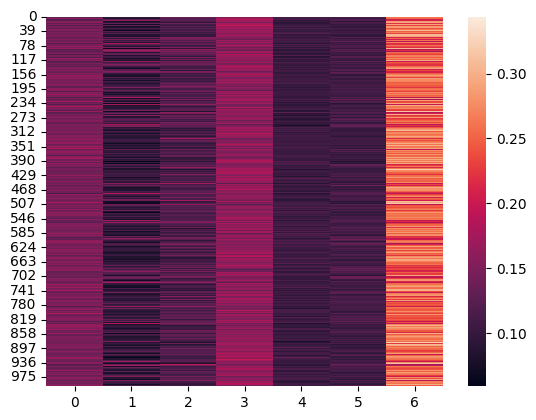

In [72]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)
gender_train_labels=training_labels


training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)
race_train_labels=training_labels

train_labels=[gender_train_labels, race_train_labels]

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)
gender_test_labels=testing_labels


testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
testing_labels=testing_labels.drop('gender', axis=1)
#testing_labels=testing_labels.drop('race',axis=1)
race_test_labels=testing_labels

test_labels=[gender_test_labels, race_test_labels]

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im
    
mod_4 = run_task_4(training_images=training_images, testing_images=testing_images, training_labels=train_labels, testing_labels=test_labels)

Task 5 of Project 3.  Create Your Own Convolutional Neural Network On Both Tasks Simultaneously.

In [73]:
def run_task_5(training_images=None):
    #build the encoder network    
    latent_dim = 5

    input_img = layers.Input(shape=(32,32,1), name='encoder_input')
    x = layers.Conv2D(filters=40,kernel_size=(4,4),activation='relu',strides=1,padding='same')(input_img)
    x = layers.Conv2D(filters=20,kernel_size=(5,5),activation='relu',strides=(2,2),padding='same')(x)
    conv_shape = K.int_shape(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=32, activation='relu')(x)
    z_mu = layers.Dense(units=latent_dim, name='latent_mu')(x)
    z_sigma = layers.Dense(units=latent_dim, name='latent_sigma')(x)
    def sample_z(args):
        z_mu, z_sigma = args
        eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
        return z_mu + K.exp(z_sigma / 2) * eps
    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])
    encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')  
    
    #build the decoder network
    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
    x = layers.Dense(units=(conv_shape[1]*conv_shape[2]*conv_shape[3]), activation='relu')(decoder_input)
    x = layers.Reshape(target_shape=(conv_shape[1],conv_shape[2],conv_shape[3]))(x)
    x = layers.Conv2DTranspose(filters=20, kernel_size=(5,5), padding='same', activation='relu', strides=(2,2))(x)
    x = layers.Conv2DTranspose(filters=1,kernel_size=(4,4),activation='sigmoid',strides=1,padding='same')(x)
    
    decoder = Model(decoder_input, x, name='decoder')
    z_decoded = decoder(z)
    
    class CustomLayer(tf.keras.layers.Layer):
        def vae_loss(self, x, z_decoded):
            x = K.flatten(x)
            z_decoded = K.flatten(z_decoded)
            
            recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
            
            kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=1)
            return K.mean(recon_loss + kl_loss)
        
        def call(self, inputs):
            x = inputs[0]
            z_decoded = inputs[1]
            loss = self.vae_loss(x, z_decoded)
            self.add_loss(loss, inputs=inputs)
            return x    

    y = CustomLayer()([input_img, z_decoded])
    vae = Model(input_img, y, name='vae')
    vae.compile(optimizer='adam', loss=None)
    vae.fit(training_images, None, epochs=5, batch_size=32, validation_split=0.2)

In [74]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im


mod_5 = run_task_5(training_images=training_images)

Epoch 1/5


TypeError: in user code:

    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics.py", line 467, in update_state  **
        update_total_op = self.total.assign_add(value_sum)
    File "c:\Users\conno\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\keras_tensor.py", line 255, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum_2/Sum:0', description="created by layer 'tf.math.reduce_sum_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
